# Tutorial 4: Calibrate the evidence values against noise

Evidence calibration computes ln_evidence on Gaussian noise using the same setup (par_dic_0, extrinsic samples, banks) from a completed inference run. This helps calibrate and validate the evidence: on pure noise, ln_evidence should be lower than on real data with a signal.

**Workflow:**
1. Create mock data and bank
2. Run inference to produce a rundir
3. Run evidence calibration on noise (replace data with Gaussian noise, recompute ln_evidence)
4. Validate by running on the original event data to verify we reproduce the rundir's ln_evidence

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import libraries and set up the artifacts directory.

In [27]:
import sys

sys.path.append("../..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
from cogwheel.utils import read_json

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from cogwheel import data, gw_utils, gw_plotting, utils, prior_ratio
from cogwheel.gw_prior import IntrinsicIASPrior
from cogwheel.posterior import Posterior
from cogwheel.likelihood import RelativeBinningLikelihood
from dot_pe import inference, waveform_banks, config
from dot_pe.power_law_mass_prior import PowerLawIntrinsicIASPrior

# Set up artifacts directory for all outputs
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True)

## Step 1: Create Mock Data and Small Bank

We use the methods from tutorials 1 and 2 to create a bank and generate an injection. This tutorial uses a 2-detector (HL) setup for faster execution.


In [3]:
# Create 2-detector injection
eventname = "event_with_signal"
# Injection parameters (chirp mass, mass ratio, spins, sky location, distance, etc.)
chirp_mass = 20.0
q = 0.7
m1, m2 = gw_utils.mchirpeta_to_m1m2(chirp_mass, gw_utils.q_to_eta(q))

injection_par_dic = dict(
    m1=m1,
    m2=m2,
    ra=0.5,
    dec=0.5,
    iota=np.pi / 3,
    psi=1.0,
    phi_ref=12.0,
    s1z=0.3,
    s2z=0.3,
    s1x_n=0.1,
    s1y_n=0.2,
    s2x_n=0.3,
    s2y_n=-0.2,
    l1=0.0,
    l2=0.0,
    tgps=0.0,
    f_ref=50.0,
    d_luminosity=2000.0,
    t_geocenter=0.0,
)


In [ ]:
event_data = data.EventData.gaussian_noise(
    eventname=eventname,
    detector_names="HL",
    duration=120.0,
    asd_funcs=["asd_H_O3", "asd_L_O3"],
    tgps=0.0,
    fmax=1600.0,
    seed=20223001,
)

# Inject signal
event_data.inject_signal(injection_par_dic, "IMRPhenomXPHM")
snr = np.sqrt(
    2 * (event_data.injection["d_h"] - 0.5 * event_data.injection["h_h"]).sum()
)
print(f"Injection SNR: {snr:.2f}")

# Save event data
event_path = ARTIFACTS_DIR / f"{eventname}.npz"
event_data.to_npz(filename=event_path, overwrite=True)
print(f"Saved event data to: {event_path}")

In [ ]:
# Create a bank for tutorial
bank_dir = ARTIFACTS_DIR / "bank"
bank_dir.mkdir(parents=True, exist_ok=True)

bank_size = 2**16
mchirp_min = 15
mchirp_max = 30
q_min = 0.2
f_ref = 50.0
seed = 777
n_pool = 4
blocksize = 4096
approximant = "IMRPhenomXPHM"

# Generate bank samples
powerlaw_prior = PowerLawIntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)
ias_prior = IntrinsicIASPrior(
    mchirp_range=(mchirp_min, mchirp_max),
    q_min=q_min,
    f_ref=f_ref,
)
pr_ratio = prior_ratio.PriorRatio(ias_prior, powerlaw_prior)
# preemptive bugfix: sometimes not all matching items are removed
prior_ratio._remove_matching_items(
    pr_ratio._numerator_subpriors, pr_ratio._denominator_subpriors
)

print(f"Generating {bank_size:,} bank samples...")
bank_samples = powerlaw_prior.generate_random_samples(
    bank_size, seed=seed, return_lnz=False
)

# Compute derived quantities and weights
bank_samples["mchirp"] = gw_utils.m1m2_to_mchirp(bank_samples["m1"], bank_samples["m2"])
bank_samples["lnq"] = np.log(bank_samples["m2"] / bank_samples["m1"])
bank_samples["chieff"] = gw_utils.chieff(
    *bank_samples[["m1", "m2", "s1z", "s2z"]].values.T
)

bank_samples["log_prior_weights"] = bank_samples.apply(
    lambda row: pr_ratio.ln_prior_ratio(**row.to_dict()), axis=1
)



# Save bank
bank_columns = [
    "m1",
    "m2",
    "s1z",
    "s1x_n",
    "s1y_n",
    "s2z",
    "s2x_n",
    "s2y_n",
    "iota",
    "log_prior_weights",
]
samples_path = bank_dir / "intrinsic_sample_bank.feather"
bank_samples[bank_columns].to_feather(samples_path)

# Save bank config
bank_config = {
    "bank_size": bank_size,
    "mchirp_min": mchirp_min,
    "mchirp_max": mchirp_max,
    "q_min": q_min,
    "f_ref": f_ref,
    "fbin": config.DEFAULT_FBIN.tolist(),
    "approximant": approximant,
    "m_arr": [2, 1, 3, 4],
    "seed": seed,
}
bank_config_path = bank_dir / "bank_config.json"
with open(bank_config_path, "w") as f:
    json.dump(bank_config, f, indent=4)

print(f"Saved bank to: {bank_dir}")
print(f"Bank size: {len(bank_samples):,} samples")

# Generate waveforms from bank samples (this may take a few minutes)
waveform_dir = bank_dir / "waveforms"
print(f"Generating waveforms using {n_pool} cores...")
waveform_banks.create_waveform_bank_from_samples(
    samples_path=samples_path,
    bank_config_path=bank_config_path,
    waveform_dir=waveform_dir,
    n_pool=n_pool,
    blocksize=blocksize,
    approximant=approximant,
)
print("Waveform generation complete!")

## Step 2: Run inference

Run full inference to produce a completed rundir. We need this rundir for evidence calibration (it provides par_dic_0, extrinsic samples, bank indices, etc.).


In [ ]:
# Create a new rundir for streamlined run
event_dir = ARTIFACTS_DIR / eventname
event_dir.mkdir(parents=True, exist_ok=True)
event_data_path = ARTIFACTS_DIR / f"{eventname}.npz"
bank_dir = ARTIFACTS_DIR / "bank"
bank_df = pd.read_feather(bank_dir / "intrinsic_sample_bank.feather")

n_int = len(bank_df)
n_ext = 1024
n_phi = 50
n_t = 128
seed_ext = sum([int(str(i) * i) for i in range(1, 10)])
blocksize = 2048
single_detector_blocksize = 2048
mchirp_guess = chirp_mass
# Run streamlined inference (run_and_profile wraps run() with optional profiling)
print("Running streamlined inference with inference.run()...")
final_rundir = inference.run_and_profile(
    event=event_data_path,
    bank_folder=bank_dir,
    n_int=n_int,
    n_ext=n_ext,
    n_phi=n_phi,
    n_t=n_t,
    blocksize=blocksize,
    single_detector_blocksize=single_detector_blocksize,
    seed=seed_ext,
    event_dir=str(event_dir),
    mchirp_guess=mchirp_guess,
    preselected_indices=None,
    max_incoherent_lnlike_drop=20,
    max_bestfit_lnlike_diff=20,
    draw_subset=True,
)

print("\nStreamlined inference complete!")
print(f"Results saved to: {final_rundir}")

# Load summary
summary_path = final_rundir / "summary_results.json"
summary = utils.read_json(summary_path)
print("\nSummary:")
print(f"  n_effective: {summary['n_effective']:.2f}")
print(f"  n_effective_i: {summary['n_effective_i']:.2f}")
print(f"  n_effective_e: {summary['n_effective_e']:.2f}")
print(f"  ln_evidence: {summary['ln_evidence']:.2f}")

# Load final samples
final_samples = pd.read_feather(final_rundir / "samples.feather")
print(f"\nFinal samples shape: {final_samples.shape}")
print(f"Final samples saved to: {final_rundir / 'samples.feather'}")

In [ ]:
# Create corner plot with true injection parameters

# Compute true values for plotting
true_mchirp = gw_utils.m1m2_to_mchirp(injection_par_dic["m1"], injection_par_dic["m2"])
true_lnq = np.log(injection_par_dic["m2"] / injection_par_dic["m1"])
true_chieff = gw_utils.chieff(
    injection_par_dic["m1"],
    injection_par_dic["m2"],
    injection_par_dic["s1z"],
    injection_par_dic["s2z"],
)

true_values = injection_par_dic | {
    "mchirp": true_mchirp,
    "lnq": true_lnq,
    "chieff": true_chieff,
}

# Load standardized samples (created in previous cell)
samples_path = sorted(
    event_dir.glob("run_*/samples.feather"),
    key=lambda x: int(x.parent.stem.split("_")[-1]),
)[-1]
samples = pd.read_feather(samples_path)

# Create corner plot

params = [
    "mchirp",
    "lnq",
    "chieff",
    "iota",
    "ra",
    "dec",
    "d_luminosity",
    "bestfit_lnlike",
]
corner_plot = gw_plotting.CornerPlot(
    samples,
    params=params,
    smooth=1.0,
)
corner_plot.plot(max_figsize=7)

# Add true injection parameters
corner_plot.scatter_points(
    true_values, colors="red", marker=".", s=200, label="Injection"
)

## Step 3: Evidence calibration on noise

Replace the data with Gaussian noise and recompute ln_evidence using the same setup from the rundir. By default, `create_noise_event_data` uses the event's PSD (recovered from wht_filter) and we pass the resulting noise to `compute_evidence_on_noise`.

In [21]:
eventname = "event_with_signal"
event_dir = Path(ARTIFACTS_DIR / eventname)

Below: original event strain vs. simulated Gaussian noise in the frequency domain (one subplot per detector).

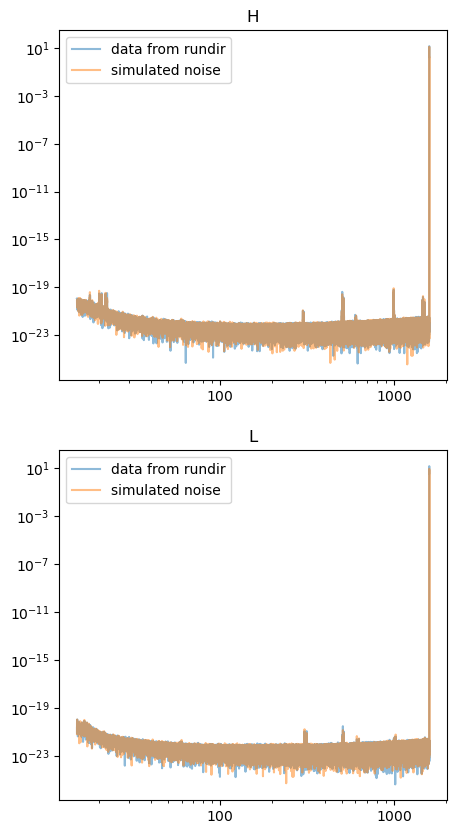

In [22]:
from dot_pe import evidence_calibration

# Resolve rundir to the latest run in the event directory
rundir = sorted(
    event_dir.glob("run_*/summary_results.json"),
    key=lambda x: int(x.parent.stem.split("_")[-1]),
)[-1].parent
# Create Gaussian noise event data with PSD from the event (by default uses wht_filter)
noise_data = evidence_calibration.create_noise_event_data(rundir, observing_run="O4")

event_data = data.EventData.from_npz(filename=rundir / (eventname + ".npz"))


fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))

for det_idx, det_name in enumerate(event_data.detector_names):
    axs[det_idx].loglog(
        event_data.frequencies[event_data.fslice],
        np.abs(event_data.strain[det_idx, event_data.fslice]),
        alpha=0.5,
        label="data from rundir",
    )
    axs[det_idx].loglog(
        noise_data.frequencies[noise_data.fslice],
        np.abs(noise_data.strain[det_idx, noise_data.fslice]),
        alpha=0.5,
        label="simulated noise",
    )
    axs[det_idx].set_title(det_name)
    axs[det_idx].legend()


In [23]:
# Recompute ln_evidence using rundir setup but with noise instead of real data
ln_evidence, ln_evidence_discarded = evidence_calibration.compute_evidence_on_noise(
    rundir=rundir, event_data_noise=noise_data
)

Slim evidence blocks: 100%|██████████| 32/32 [01:17<00:00,  2.42s/it]


In [25]:
print("From rundir:")
summary_results = read_json(rundir / "summary_results.json")
print("ln evidence:", summary_results["ln_evidence"])
print("ln evidence discarded:", summary_results["ln_evidence_discarded"])
print("Using evidence_calibration code on noise:")
print("ln evidence:", ln_evidence)
print("ln evidence discarded:", ln_evidence_discarded)


From rundir:
ln evidecen: 12.07979133605388
ln evidence discarded: 2.381006217706066
Using evidence_calibration code on noise:
ln evidecen: -20.171190311304724
ln evidence discarded: -inf


## Step 4: Validation on same data

Run evidence calibration on the original event data (with signal, not noise). This should reproduce the rundir's ln_evidence from summary_results.json and validates that the slim evidence path matches the full inference.

In [ ]:
rundir = "../notebooks/03_run_inference/artifacts/run_multibank/run_1"

# Use original event npz (with signal, not noise) to validate we reproduce rundir's ln_evidence
ln_evidence, ln_evidence_discarded = evidence_calibration.compute_evidence_on_noise(
    rundir=rundir,
    event_data_noise="../notebooks/03_run_inference/artifacts/run_multibank/run_1/tutorial_inference_event.npz",
)

Slim evidence blocks: 100%|██████████| 16/16 [00:56<00:00,  3.55s/it]


In [ ]:

print("From rundir:")
summary_results = read_json(Path(rundir) / "summary_results.json")
print("ln evidence:", summary_results["ln_evidence"])
print("ln evidence discarded:", summary_results["ln_evidence_discarded"])
print("Using evidence_calibration code on same data (not noise):")
print("ln evidence:", ln_evidence)
print("ln evidence discarded:", ln_evidence_discarded)

From rundir:
ln evidecen: 3.0000999470408543
ln evidence discarded: -5.6680552506499335
Using evidence_calibration code on same data (not noise):
ln evidecen: 3.0004031376317037
ln evidence discarded: -inf
